# Setup

In [49]:
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
if not OPENAI_API_KEY:
    print("WARNING: OPENAI_API_KEY not set. Set it with %env or your environment before running API cells.")

In [50]:
import os
import re
import time
import json
import math
import numpy as np
import xml.etree.ElementTree as ET
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from collections import Counter
import hashlib
import random
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Any
import uuid
import logging

# Functions

In [51]:
# ---------- Text utilities ----------
def normalize_text(s: str) -> str:
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()


# ---------- Simple cosine similarity ----------
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

# Prompts

In [52]:
# ---------- Prompt store (XML) ----------
PROMPTS_XML = """<?xml version="1.0" encoding="UTF-8"?>
<prompts version="1.0">
  <prompt id="classify_scope.system"><![CDATA[
You are a domain gate for a RAG system.
Decide whether the user query is IN SCOPE for one of the allowed DOMAINS, or OUT OF SCOPE.
Rules:
1) If none of the domains clearly apply, set in_scope=false and domain=null.
2) Domain must be one of DOMAINS or null. Never invent domains.
3) Be conservative: low confidence => out of scope.
Return STRICT JSON with keys: in_scope (bool), domain (string|null), reason (string).
  ]]></prompt>

  <prompt id="classify_scope.user"><![CDATA[
DOMAINS = {DOMAINS}
QUERY = {QUERY}
  ]]></prompt>

  <prompt id="generate.system"><![CDATA[
You are a RAG assistant. Use ONLY the provided context.
If the question is out of scope, answer: "I don't have information on this topic."
Keep answers concise (≤ 6 sentences).
When evidence exists, reference sources in-text using [doc_id] markers that match citations.
Do not fabricate links or content beyond the given context.
  ]]></prompt>

  <prompt id="generate.user"><![CDATA[
Question: {QUERY}

Context:
{CONTEXT}
  ]]></prompt>
</prompts>
"""

# Classes

In [53]:

class _SafeDict(dict):
    def __missing__(self, key):
        return "{" + key + "}"


class PromptStore:
    def __init__(self, xml_text: str):
        self._prompts: Dict[str, str] = {}
        self._load(xml_text)

    def _load(self, xml_text: str):
        root = ET.fromstring(xml_text)
        for node in root.findall(".//prompt"):
            pid = node.attrib.get("id")
            if not pid:
                continue
            text = (node.text or "").strip()
            self._prompts[pid] = text

    def get(self, prompt_id: str) -> str:
        if prompt_id not in self._prompts:
            raise KeyError(f"Prompt id not found: {prompt_id}")
        return self._prompts[prompt_id]

    def render(self, prompt_id: str, **kwargs) -> str:
        return self.get(prompt_id).format_map(_SafeDict(**kwargs))


prompts = PromptStore(PROMPTS_XML)

print("Cell 1 ready: utils + PromptStore loaded with prompt ids",
list(prompts._prompts.keys()))

Cell 1 ready: utils + PromptStore loaded with prompt ids ['classify_scope.system', 'classify_scope.user', 'generate.system', 'generate.user']


# Embeddings

In [54]:
client = OpenAI(api_key=OPENAI_API_KEY)
EMBED_MODEL = os.getenv("OPENAI_MODEL_EMBED", "text-embedding-3-small")  # 1536 dims

def _l2_normalize_rows(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    return X / norms

def embed_texts_openai(texts: List[str], model: str = EMBED_MODEL) -> np.ndarray:
    """
    Returns a 2D numpy array [n_texts, dim], L2-normalized.
    """
    resp = client.embeddings.create(model=model, input=texts)
    vecs = [d.embedding for d in resp.data]
    X = np.array(vecs, dtype=np.float32)
    return _l2_normalize_rows(X)

def embed_text_openai(text: str, model: str = EMBED_MODEL) -> np.ndarray:
    return embed_texts_openai([text], model=model)[0]

# Intelligent Technical Support System with Personalized Recommendations

This notebook implements a RAG (Retrieval-Augmented Generation) system for the Shakers platform that:
1. Answers technical questions about the platform
2. Provides personalized recommendations based on user queries
3. Includes performance metrics and evaluation

## System Architecture
- **Knowledge Base**: Mock documentation about Shakers platform
- **Vector Store**: OpenAI embeddings for semantic search
- **RAG Engine**: LLM-powered responses with context
- **Recommendation System**: Personalized resource suggestions
- **Metrics Dashboard**: Performance evaluation


In [55]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


## Step 1: Knowledge Base Creation

Creating a comprehensive mock knowledge base with Shakers platform documentation covering:
- Platform overview and features
- Payment system and billing
- Freelancer profiles and matching
- Client onboarding process
- Technical support procedures


In [56]:
# Mock Knowledge Base for Shakers Platform
@dataclass
class Document:
    """Represents a document in the knowledge base."""
    id: str
    title: str
    content: str
    category: str
    tags: List[str] = field(default_factory=list)
    url: Optional[str] = None
    last_updated: datetime = field(default_factory=datetime.now)

# Comprehensive mock documentation
KNOWLEDGE_BASE = [
    Document(
        id="shakers_overview",
        title="Shakers Platform Overview",
        content="""
        Shakers is a leading freelance marketplace connecting businesses with top-tier talent worldwide. 
        Our platform specializes in matching clients with skilled professionals across various industries 
        including software development, design, marketing, and consulting. Founded in 2020, Shakers has 
        facilitated over 50,000 successful projects with a 95% client satisfaction rate. The platform 
        offers advanced matching algorithms, secure payment processing, and comprehensive project management tools.
        """,
        category="platform",
        tags=["overview", "introduction", "marketplace"],
        url="https://shakers.com/about"
    ),
    
    Document(
        id="payment_system",
        title="How Payments Work on Shakers",
        content="""
        Shakers uses a secure escrow payment system to protect both clients and freelancers. 
        When a project is awarded, clients deposit funds into an escrow account managed by Shakers. 
        Payments are released in milestones as work is completed and approved. We support multiple 
        payment methods including credit cards, PayPal, and bank transfers. Our platform charges 
        a 3% service fee on completed projects. All transactions are encrypted and PCI compliant. 
        Freelancers can withdraw funds to their bank account or PayPal with processing times of 
        1-3 business days.
        """,
        category="payments",
        tags=["payment", "escrow", "billing", "fees"],
        url="https://shakers.com/payments"
    ),
    
    Document(
        id="freelancer_profiles",
        title="Freelancer Profiles and Verification",
        content="""
        Freelancers on Shakers create detailed profiles showcasing their skills, experience, and portfolio. 
        All freelancers undergo a verification process including identity verification, skill assessments, 
        and portfolio review. Profiles include work history, client reviews, skill certifications, and 
        hourly rates. Our matching algorithm considers freelancer expertise, availability, location, 
        and past performance to suggest the best candidates for each project. Top-rated freelancers 
        receive priority in search results and recommendations.
        """,
        category="freelancers",
        tags=["profiles", "verification", "skills", "matching"],
        url="https://shakers.com/freelancers"
    ),
    
    Document(
        id="client_onboarding",
        title="Client Onboarding Process",
        content="""
        New clients can join Shakers by creating an account and completing a brief onboarding process. 
        This includes company verification, project requirements definition, and budget setting. 
        Clients can post projects with detailed descriptions, required skills, timeline, and budget. 
        Our system automatically matches projects with suitable freelancers and sends notifications. 
        Clients can review proposals, conduct interviews, and select the best candidate. 
        We provide project management tools, communication channels, and milestone tracking.
        """,
        category="clients",
        tags=["onboarding", "projects", "matching", "management"],
        url="https://shakers.com/clients"
    ),
    
    Document(
        id="android_development",
        title="Android Development Services",
        content="""
        Shakers hosts thousands of skilled Android developers with expertise in Java, Kotlin, 
        Android Studio, and modern development frameworks. Our Android developers specialize in 
        native app development, cross-platform solutions using React Native or Flutter, 
        and backend integration. They have experience with Google Play Store submissions, 
        app optimization, and security best practices. Typical project rates range from $25-150/hour 
        depending on experience level and project complexity. Most developers have 3+ years of 
        Android development experience and portfolio samples.
        """,
        category="services",
        tags=["android", "mobile", "development", "kotlin", "java"],
        url="https://shakers.com/services/android"
    ),
    
    Document(
        id="project_management",
        title="Project Management Tools",
        content="""
        Shakers provides comprehensive project management tools to streamline collaboration between 
        clients and freelancers. Features include milestone tracking, file sharing, real-time messaging, 
        time tracking, and progress reports. Clients can set project milestones, approve deliverables, 
        and release payments accordingly. The platform supports agile methodologies, sprint planning, 
        and team collaboration. All communication is logged and searchable for project transparency. 
        Integration with popular tools like Slack, Trello, and GitHub is available.
        """,
        category="tools",
        tags=["project-management", "collaboration", "milestones", "communication"],
        url="https://shakers.com/tools"
    ),
    
    Document(
        id="security_privacy",
        title="Security and Privacy",
        content="""
        Shakers prioritizes security and privacy for all users. We use enterprise-grade encryption 
        for all data transmission and storage. User data is protected under GDPR and CCPA compliance 
        standards. All freelancers undergo background checks and identity verification. 
        Intellectual property rights are clearly defined in our terms of service. 
        We provide NDAs for sensitive projects and secure file sharing capabilities. 
        Regular security audits and penetration testing ensure platform integrity.
        """,
        category="security",
        tags=["security", "privacy", "compliance", "encryption"],
        url="https://shakers.com/security"
    ),
    
    Document(
        id="support_procedures",
        title="Technical Support Procedures",
        content="""
        Shakers offers 24/7 technical support through multiple channels including live chat, 
        email, and phone. Our support team handles account issues, payment problems, 
        technical difficulties, and dispute resolution. Response times are typically under 
        2 hours for urgent issues and 24 hours for general inquiries. We maintain a 
        comprehensive FAQ database and video tutorials. For complex technical issues, 
        we provide screen sharing and remote assistance. All support interactions are logged 
        for quality assurance and training purposes.
        """,
        category="support",
        tags=["support", "help", "troubleshooting", "contact"],
        url="https://shakers.com/support"
    )
]

print(f"✅ Knowledge base created with {len(KNOWLEDGE_BASE)} documents")
print(f"📊 Categories: {set(doc.category for doc in KNOWLEDGE_BASE)}")


✅ Knowledge base created with 8 documents
📊 Categories: {'support', 'payments', 'freelancers', 'clients', 'platform', 'security', 'tools', 'services'}


## Step 2: Document Ingestion and Vectorization

Implementing the vector store and embedding system for semantic search:
- Document preprocessing and chunking
- OpenAI embedding generation
- Vector storage and indexing
- Similarity search capabilities


In [57]:
# Vector Store Implementation
@dataclass
class VectorDocument:
    """Represents a document with its embedding vector."""
    doc_id: str
    title: str
    content: str
    category: str
    tags: List[str]
    url: Optional[str]
    embedding: np.ndarray
    chunk_index: int = 0
    last_updated: datetime = field(default_factory=datetime.now)

class VectorStore:
    """Simple in-memory vector store for document embeddings."""
    
    def __init__(self):
        self.documents: List[VectorDocument] = []
        self.embeddings_matrix: Optional[np.ndarray] = None
        self.is_indexed = False
    
    def add_documents(self, documents: List[Document]) -> None:
        """Add documents to the vector store and generate embeddings."""
        logger.info(f"Adding {len(documents)} documents to vector store...")
        
        for doc in documents:
            # Generate embedding for the document content
            content_text = f"{doc.title}\n\n{doc.content}"
            embedding = embed_text_openai(content_text)
            
            vector_doc = VectorDocument(
                doc_id=doc.id,
                title=doc.title,
                content=doc.content,
                category=doc.category,
                tags=doc.tags,
                url=doc.url,
                embedding=embedding,
                last_updated=doc.last_updated
            )
            
            self.documents.append(vector_doc)
        
        self._build_index()
        logger.info(f"✅ Vector store updated with {len(self.documents)} documents")
    
    def _build_index(self) -> None:
        """Build the embeddings matrix for efficient similarity search."""
        if not self.documents:
            return
        
        embeddings = [doc.embedding for doc in self.documents]
        self.embeddings_matrix = np.array(embeddings)
        self.is_indexed = True
        logger.info(f"✅ Embeddings index built with shape {self.embeddings_matrix.shape}")
    
    def search(self, query: str, top_k: int = 5, threshold: float = 0.7) -> List[Tuple[VectorDocument, float]]:
        """Search for similar documents using cosine similarity."""
        if not self.is_indexed:
            raise ValueError("Vector store not indexed. Call add_documents first.")
        
        # Generate query embedding
        query_embedding = embed_text_openai(query)
        
        # Calculate cosine similarities
        similarities = np.dot(self.embeddings_matrix, query_embedding)
        
        # Get top-k results above threshold
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            similarity = float(similarities[idx])
            if similarity >= threshold:
                results.append((self.documents[idx], similarity))
        
        return results
    
    def get_document_by_id(self, doc_id: str) -> Optional[VectorDocument]:
        """Retrieve a document by its ID."""
        for doc in self.documents:
            if doc.doc_id == doc_id:
                return doc
        return None

# Initialize vector store
vector_store = VectorStore()

print("✅ Vector store implementation ready")


✅ Vector store implementation ready


In [58]:
# Populate vector store with knowledge base
print("🔄 Generating embeddings for knowledge base documents...")
vector_store.add_documents(KNOWLEDGE_BASE)

print(f"✅ Vector store populated with {len(vector_store.documents)} documents")
print(f"📊 Embedding dimensions: {vector_store.embeddings_matrix.shape[1] if vector_store.embeddings_matrix is not None else 'Not built'}")

# Test the vector store with a sample query
test_query = "How do payments work on the platform?"
results = vector_store.search(test_query, top_k=3)

print(f"\n🔍 Test search for: '{test_query}'")
for i, (doc, similarity) in enumerate(results, 1):
    print(f"{i}. {doc.title} (similarity: {similarity:.3f})")
    print(f"   Category: {doc.category}")
    print(f"   URL: {doc.url}")
    print()


INFO:__main__:Adding 8 documents to vector store...


🔄 Generating embeddings for knowledge base documents...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:__main__:✅ Embeddings index built with shape (8, 1536)
INFO:__main__:✅ Vector store updated with 8 documents


✅ Vector store populated with 8 documents
📊 Embedding dimensions: 1536


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔍 Test search for: 'How do payments work on the platform?'


## Step 3: RAG Query Service Implementation

Building the core RAG system with:
- Query classification (in-scope vs out-of-scope)
- Document retrieval and ranking
- LLM-powered response generation
- Source citation and references


In [59]:
# RAG Query Service Implementation
@dataclass
class QueryResult:
    """Represents the result of a RAG query."""
    query: str
    response: str
    sources: List[VectorDocument]
    response_time: float
    is_in_scope: bool
    domain: Optional[str]
    confidence: float
    timestamp: datetime = field(default_factory=datetime.now)

class RAGQueryService:
    """Main RAG service for processing user queries."""
    
    def __init__(self, vector_store: VectorStore, client: OpenAI):
        self.vector_store = vector_store
        self.client = client
        self.domains = ["platform", "payments", "freelancers", "clients", "services", "tools", "security", "support"]
        
    def classify_query_scope(self, query: str) -> Tuple[bool, Optional[str], str]:
        """Classify if query is in scope and determine domain."""
        try:
            system_prompt = prompts.render("classify_scope.system")
            user_prompt = prompts.render("classify_scope.user", DOMAINS=self.domains, QUERY=query)
            
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                max_tokens=200
            )
            
            result = json.loads(response.choices[0].message.content)
            return result["in_scope"], result["domain"], result["reason"]
            
        except Exception as e:
            logger.error(f"Error in query classification: {e}")
            return False, None, f"Classification error: {str(e)}"
    
    def retrieve_relevant_documents(self, query: str, top_k: int = 3) -> List[Tuple[VectorDocument, float]]:
        """Retrieve relevant documents for the query."""
        return self.vector_store.search(query, top_k=top_k, threshold=0.6)
    
    def generate_response(self, query: str, documents: List[VectorDocument]) -> str:
        """Generate a contextualized response using retrieved documents."""
        if not documents:
            return "I don't have information on this topic in our knowledge base."
        
        # Build context from retrieved documents
        context_parts = []
        for i, doc in enumerate(documents, 1):
            context_parts.append(f"[doc_{i}] {doc.title}\n{doc.content}")
        
        context = "\n\n".join(context_parts)
        
        # Generate response using LLM
        system_prompt = prompts.render("generate.system")
        user_prompt = prompts.render("generate.user", QUERY=query, CONTEXT=context)
        
        try:
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.3,
                max_tokens=500
            )
            
            return response.choices[0].message.content.strip()
            
        except Exception as e:
            logger.error(f"Error generating response: {e}")
            return f"I encountered an error while processing your query: {str(e)}"
    
    def query(self, user_query: str) -> QueryResult:
        """Process a user query and return a complete result."""
        start_time = time.time()
        
        # Classify query scope
        is_in_scope, domain, reason = self.classify_query_scope(user_query)
        
        if not is_in_scope:
            response_time = time.time() - start_time
            return QueryResult(
                query=user_query,
                response=f"I don't have information on this topic. {reason}",
                sources=[],
                response_time=response_time,
                is_in_scope=False,
                domain=None,
                confidence=0.0
            )
        
        # Retrieve relevant documents
        retrieved_docs = self.retrieve_relevant_documents(user_query)
        
        if not retrieved_docs:
            response_time = time.time() - start_time
            return QueryResult(
                query=user_query,
                response="I don't have specific information about this topic in our knowledge base.",
                sources=[],
                response_time=response_time,
                is_in_scope=True,
                domain=domain,
                confidence=0.0
            )
        
        # Generate response
        documents = [doc for doc, _ in retrieved_docs]
        response = self.generate_response(user_query, documents)
        
        # Calculate confidence based on similarity scores
        avg_similarity = np.mean([score for _, score in retrieved_docs])
        confidence = min(avg_similarity, 1.0)
        
        response_time = time.time() - start_time
        
        return QueryResult(
            query=user_query,
            response=response,
            sources=documents,
            response_time=response_time,
            is_in_scope=True,
            domain=domain,
            confidence=confidence
        )

# Initialize RAG service
rag_service = RAGQueryService(vector_store, client)

print("✅ RAG Query Service initialized")


✅ RAG Query Service initialized


## Step 4: Personalized Recommendation System

Implementing intelligent recommendations based on:
- User query history analysis
- Document category preferences
- Similar user behavior patterns
- Content-based filtering


In [60]:
# Personalized Recommendation System
@dataclass
class UserProfile:
    """Represents a user's profile and preferences."""
    user_id: str
    query_history: List[str] = field(default_factory=list)
    category_preferences: Dict[str, float] = field(default_factory=dict)
    document_interactions: Dict[str, int] = field(default_factory=dict)
    created_at: datetime = field(default_factory=datetime.now)
    last_active: datetime = field(default_factory=datetime.now)

@dataclass
class Recommendation:
    """Represents a personalized recommendation."""
    document: VectorDocument
    score: float
    reason: str
    category: str

class RecommendationEngine:
    """Engine for generating personalized recommendations."""
    
    def __init__(self, vector_store: VectorStore):
        self.vector_store = vector_store
        self.user_profiles: Dict[str, UserProfile] = {}
        
    def get_or_create_user_profile(self, user_id: str) -> UserProfile:
        """Get existing user profile or create a new one."""
        if user_id not in self.user_profiles:
            self.user_profiles[user_id] = UserProfile(user_id=user_id)
        return self.user_profiles[user_id]
    
    def update_user_profile(self, user_id: str, query: str, interacted_docs: List[VectorDocument]) -> None:
        """Update user profile based on query and interactions."""
        profile = self.get_or_create_user_profile(user_id)
        
        # Update query history
        profile.query_history.append(query)
        profile.last_active = datetime.now()
        
        # Update category preferences based on interacted documents
        for doc in interacted_docs:
            category = doc.category
            if category not in profile.category_preferences:
                profile.category_preferences[category] = 0.0
            profile.category_preferences[category] += 1.0
            
            # Update document interactions
            doc_id = doc.doc_id
            if doc_id not in profile.document_interactions:
                profile.document_interactions[doc_id] = 0
            profile.document_interactions[doc_id] += 1
        
        # Normalize category preferences
        total_interactions = sum(profile.category_preferences.values())
        if total_interactions > 0:
            for category in profile.category_preferences:
                profile.category_preferences[category] /= total_interactions
    
    def generate_recommendations(self, user_id: str, query: str, top_k: int = 3) -> List[Recommendation]:
        """Generate personalized recommendations for a user."""
        profile = self.get_or_create_user_profile(user_id)
        
        # Get all documents
        all_docs = self.vector_store.documents
        
        # Calculate recommendation scores
        recommendations = []
        
        for doc in all_docs:
            score = 0.0
            reasons = []
            
            # Category preference score
            category_score = profile.category_preferences.get(doc.category, 0.0)
            score += category_score * 0.4
            if category_score > 0:
                reasons.append(f"Matches your interest in {doc.category}")
            
            # Content similarity to query
            query_embedding = embed_text_openai(query)
            similarity = float(np.dot(doc.embedding, query_embedding))
            score += similarity * 0.3
            if similarity > 0.7:
                reasons.append("Highly relevant to your query")
            
            # Historical interaction score
            interaction_count = profile.document_interactions.get(doc.doc_id, 0)
            if interaction_count > 0:
                interaction_score = min(interaction_count / 5.0, 1.0)  # Cap at 1.0
                score += interaction_score * 0.2
                reasons.append("Based on your previous interests")
            
            # Recency bonus (newer documents get slight boost)
            days_since_creation = (datetime.now() - doc.last_updated).days
            recency_score = max(0, 1.0 - (days_since_creation / 365.0))  # Decay over year
            score += recency_score * 0.1
            if recency_score > 0.8:
                reasons.append("Recently updated content")
            
            if score > 0.1:  # Only include documents with meaningful scores
                reason_text = "; ".join(reasons) if reasons else "General recommendation"
                recommendations.append(Recommendation(
                    document=doc,
                    score=score,
                    reason=reason_text,
                    category=doc.category
                ))
        
        # Sort by score and return top-k
        recommendations.sort(key=lambda x: x.score, reverse=True)
        return recommendations[:top_k]
    
    def get_user_insights(self, user_id: str) -> Dict[str, Any]:
        """Get insights about user preferences and behavior."""
        profile = self.get_or_create_user_profile(user_id)
        
        # Most interested categories
        top_categories = sorted(
            profile.category_preferences.items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        
        # Most interacted documents
        top_docs = sorted(
            profile.document_interactions.items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        
        return {
            "total_queries": len(profile.query_history),
            "top_categories": top_categories,
            "most_viewed_docs": top_docs,
            "last_active": profile.last_active,
            "account_age_days": (datetime.now() - profile.created_at).days
        }

# Initialize recommendation engine
recommendation_engine = RecommendationEngine(vector_store)

print("✅ Personalized Recommendation Engine initialized")


✅ Personalized Recommendation Engine initialized


## Step 5: Metrics Dashboard

Creating a comprehensive dashboard to track:
- System performance metrics
- User engagement statistics
- Query success rates
- Response time analytics
- Recommendation effectiveness


In [61]:
# Metrics Dashboard Implementation
@dataclass
class SystemMetrics:
    """System-wide performance metrics."""
    total_queries: int = 0
    successful_queries: int = 0
    failed_queries: int = 0
    avg_response_time: float = 0.0
    total_users: int = 0
    queries_by_domain: Dict[str, int] = field(default_factory=dict)
    response_times: List[float] = field(default_factory=list)
    query_history: List[QueryResult] = field(default_factory=list)

class MetricsDashboard:
    """Dashboard for tracking and visualizing system metrics."""
    
    def __init__(self):
        self.metrics = SystemMetrics()
        
    def record_query(self, query_result: QueryResult) -> None:
        """Record a query result for metrics tracking."""
        self.metrics.query_history.append(query_result)
        self.metrics.total_queries += 1
        
        if query_result.is_in_scope:
            self.metrics.successful_queries += 1
        else:
            self.metrics.failed_queries += 1
        
        # Update response time metrics
        self.metrics.response_times.append(query_result.response_time)
        self.metrics.avg_response_time = np.mean(self.metrics.response_times)
        
        # Update domain statistics
        if query_result.domain:
            domain = query_result.domain
            if domain not in self.metrics.queries_by_domain:
                self.metrics.queries_by_domain[domain] = 0
            self.metrics.queries_by_domain[domain] += 1
    
    def get_success_rate(self) -> float:
        """Calculate query success rate."""
        if self.metrics.total_queries == 0:
            return 0.0
        return self.metrics.successful_queries / self.metrics.total_queries
    
    def get_performance_summary(self) -> Dict[str, Any]:
        """Get a summary of system performance."""
        return {
            "total_queries": self.metrics.total_queries,
            "success_rate": self.get_success_rate(),
            "avg_response_time": self.metrics.avg_response_time,
            "total_users": len(recommendation_engine.user_profiles),
            "queries_by_domain": self.metrics.queries_by_domain,
            "recent_queries": len([q for q in self.metrics.query_history 
                                 if (datetime.now() - q.timestamp).days <= 7])
        }
    
    def plot_response_times(self) -> None:
        """Plot response time distribution."""
        if not self.metrics.response_times:
            print("No response time data available")
            return
        
        plt.figure(figsize=(10, 6))
        plt.hist(self.metrics.response_times, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(self.metrics.avg_response_time, color='red', linestyle='--', 
                   label=f'Average: {self.metrics.avg_response_time:.2f}s')
        plt.xlabel('Response Time (seconds)')
        plt.ylabel('Frequency')
        plt.title('Response Time Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_domain_distribution(self) -> None:
        """Plot query distribution by domain."""
        if not self.metrics.queries_by_domain:
            print("No domain data available")
            return
        
        domains = list(self.metrics.queries_by_domain.keys())
        counts = list(self.metrics.queries_by_domain.values())
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(domains, counts, color='lightcoral', alpha=0.7, edgecolor='black')
        plt.xlabel('Domain')
        plt.ylabel('Number of Queries')
        plt.title('Query Distribution by Domain')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    str(count), ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_success_rate_trend(self) -> None:
        """Plot success rate trend over time."""
        if len(self.metrics.query_history) < 2:
            print("Insufficient data for trend analysis")
            return
        
        # Calculate rolling success rate
        window_size = max(1, len(self.metrics.query_history) // 10)
        rolling_success_rates = []
        
        for i in range(window_size, len(self.metrics.query_history) + 1):
            window_queries = self.metrics.query_history[i-window_size:i]
            successful = sum(1 for q in window_queries if q.is_in_scope)
            success_rate = successful / len(window_queries)
            rolling_success_rates.append(success_rate)
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(window_size, len(self.metrics.query_history) + 1), 
                rolling_success_rates, marker='o', linewidth=2, markersize=4)
        plt.xlabel('Query Number')
        plt.ylabel('Success Rate')
        plt.title(f'Rolling Success Rate (Window Size: {window_size})')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.show()
    
    def display_dashboard(self) -> None:
        """Display the complete metrics dashboard."""
        print("=" * 60)
        print("📊 SHAKERS RAG SYSTEM - METRICS DASHBOARD")
        print("=" * 60)
        
        summary = self.get_performance_summary()
        
        print(f"📈 Total Queries: {summary['total_queries']}")
        print(f"✅ Success Rate: {summary['success_rate']:.1%}")
        print(f"⏱️  Average Response Time: {summary['avg_response_time']:.2f}s")
        print(f"👥 Total Users: {summary['total_users']}")
        print(f"📅 Recent Queries (7 days): {summary['recent_queries']}")
        
        print("\n🏷️  Queries by Domain:")
        for domain, count in summary['queries_by_domain'].items():
            print(f"   {domain}: {count}")
        
        print("\n📊 Visualizations:")
        self.plot_response_times()
        self.plot_domain_distribution()
        self.plot_success_rate_trend()

# Initialize metrics dashboard
metrics_dashboard = MetricsDashboard()

print("✅ Metrics Dashboard initialized")


✅ Metrics Dashboard initialized


## Step 6: Complete System Integration and Testing

Creating the main system interface that combines:
- RAG query processing
- Personalized recommendations
- Metrics tracking
- User interaction management


In [62]:
# Complete System Integration
class ShakersRAGSystem:
    """Main system that integrates all components."""
    
    def __init__(self, rag_service: RAGQueryService, recommendation_engine: RecommendationEngine, 
                 metrics_dashboard: MetricsDashboard):
        self.rag_service = rag_service
        self.recommendation_engine = recommendation_engine
        self.metrics_dashboard = metrics_dashboard
    
    def process_query(self, user_id: str, query: str) -> Dict[str, Any]:
        """Process a user query and return comprehensive results."""
        print(f"🔍 Processing query for user {user_id}: '{query}'")
        
        # Process the query with RAG service
        query_result = self.rag_service.query(query)
        
        # Record metrics
        self.metrics_dashboard.record_query(query_result)
        
        # Update user profile if query was successful
        if query_result.is_in_scope and query_result.sources:
            self.recommendation_engine.update_user_profile(
                user_id, query, query_result.sources
            )
        
        # Generate personalized recommendations
        recommendations = self.recommendation_engine.generate_recommendations(user_id, query)
        
        # Prepare response
        response = {
            "query": query,
            "response": query_result.response,
            "is_in_scope": query_result.is_in_scope,
            "domain": query_result.domain,
            "confidence": query_result.confidence,
            "response_time": query_result.response_time,
            "sources": [
                {
                    "title": doc.title,
                    "category": doc.category,
                    "url": doc.url,
                    "content_preview": doc.content[:200] + "..." if len(doc.content) > 200 else doc.content
                }
                for doc in query_result.sources
            ],
            "recommendations": [
                {
                    "title": rec.document.title,
                    "category": rec.category,
                    "score": rec.score,
                    "reason": rec.reason,
                    "url": rec.document.url
                }
                for rec in recommendations
            ],
            "user_insights": self.recommendation_engine.get_user_insights(user_id)
        }
        
        return response
    
    def display_query_result(self, result: Dict[str, Any]) -> None:
        """Display query result in a formatted way."""
        print("=" * 80)
        print(f"🎯 QUERY: {result['query']}")
        print("=" * 80)
        
        print(f"📊 Status: {'✅ In Scope' if result['is_in_scope'] else '❌ Out of Scope'}")
        print(f"🏷️  Domain: {result['domain'] or 'N/A'}")
        print(f"🎯 Confidence: {result['confidence']:.2f}")
        print(f"⏱️  Response Time: {result['response_time']:.2f}s")
        
        print(f"\n💬 RESPONSE:")
        print(f"{result['response']}")
        
        if result['sources']:
            print(f"\n📚 SOURCES:")
            for i, source in enumerate(result['sources'], 1):
                print(f"{i}. {source['title']} ({source['category']})")
                print(f"   URL: {source['url']}")
                print(f"   Preview: {source['content_preview']}")
                print()
        
        if result['recommendations']:
            print(f"🎯 PERSONALIZED RECOMMENDATIONS:")
            for i, rec in enumerate(result['recommendations'], 1):
                print(f"{i}. {rec['title']} (Score: {rec['score']:.2f})")
                print(f"   Category: {rec['category']}")
                print(f"   Reason: {rec['reason']}")
                print(f"   URL: {rec['url']}")
                print()
        
        print(f"👤 USER INSIGHTS:")
        insights = result['user_insights']
        print(f"   Total Queries: {insights['total_queries']}")
        print(f"   Account Age: {insights['account_age_days']} days")
        print(f"   Last Active: {insights['last_active'].strftime('%Y-%m-%d %H:%M')}")
        
        if insights['top_categories']:
            print(f"   Top Categories: {', '.join([f'{cat} ({score:.2f})' for cat, score in insights['top_categories']])}")
        
        print("=" * 80)

# Initialize the complete system
shakers_system = ShakersRAGSystem(rag_service, recommendation_engine, metrics_dashboard)

print("✅ Complete Shakers RAG System initialized and ready!")


✅ Complete Shakers RAG System initialized and ready!


In [63]:
# Test the Complete System with Sample Queries
print("🚀 TESTING SHAKERS RAG SYSTEM")
print("=" * 50)

# Test queries covering different scenarios
test_queries = [
    "How do payments work on Shakers?",
    "I need an Android developer with 8 years of experience",
    "What is the client onboarding process?",
    "How secure is the platform?",
    "What is the weather today?",  # Out of scope query
    "Tell me about freelancer verification",
    "How does project management work?",
    "What are the platform fees?"
]

# Test with different users to show personalization (cycling through users)
test_users = ["user_001", "user_002", "user_001", "user_003", "user_001", "user_002", "user_003", "user_001"]

print(f"Testing with {len(test_queries)} queries and {len(set(test_users))} unique users...")
print()

for i, (user_id, query) in enumerate(zip(test_users, test_queries), 1):
    print(f"🧪 TEST {i}/{len(test_queries)}")
    result = shakers_system.process_query(user_id, query)
    shakers_system.display_query_result(result)
    print("\n" + "🔄" * 40 + "\n")


🚀 TESTING SHAKERS RAG SYSTEM
Testing with 8 queries and 3 unique users...

🧪 TEST 1/8
🔍 Processing query for user user_001: 'How do payments work on Shakers?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: How do payments work on Shakers?
📊 Status: ✅ In Scope
🏷️  Domain: payments
🎯 Confidence: 0.77
⏱️  Response Time: 2.14s

💬 RESPONSE:
Payments on Shakers are processed through a secure escrow system where clients deposit funds into an escrow account managed by the platform [doc_1]. Payments are released in milestones as work is completed and approved. Shakers supports various payment methods such as credit cards, PayPal, and bank transfers. A 3% service fee is charged on completed projects. Transactions are encrypted and PCI compliant. Freelancers can withdraw funds to their bank account or PayPal with processing times of 1-3 business days.

📚 SOURCES:
1. How Payments Work on Shakers (payments)
   URL: https://shakers.com/payments
   Preview: 
        Shakers uses a secure escrow payment system to protect both clients and freelancers. 
        When a project is awarded, clients deposit funds into an escrow account managed by Shakers. 
    ...

🎯 PERSONALIZED RECOMMENDATIONS:
1. 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: I need an Android developer with 8 years of experience
📊 Status: ❌ Out of Scope
🏷️  Domain: N/A
🎯 Confidence: 0.00
⏱️  Response Time: 1.16s

💬 RESPONSE:
I don't have information on this topic. Out of scope. The query is related to hiring a specific individual and not directly related to any of the allowed domains.
🎯 PERSONALIZED RECOMMENDATIONS:
1. Android Development Services (Score: 0.28)
   Category: services
   Reason: Recently updated content
   URL: https://shakers.com/services/android

2. Shakers Platform Overview (Score: 0.18)
   Category: platform
   Reason: Recently updated content
   URL: https://shakers.com/about

3. Freelancer Profiles and Verification (Score: 0.17)
   Category: freelancers
   Reason: Recently updated content
   URL: https://shakers.com/freelancers

👤 USER INSIGHTS:
   Total Queries: 0
   Account Age: 0 days
   Last Active: 2025-09-08 14:31

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄

🧪 TEST 3/8
🔍 Processing query for user user_001: 'What is the cli

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: What is the client onboarding process?
📊 Status: ✅ In Scope
🏷️  Domain: clients
🎯 Confidence: 0.67
⏱️  Response Time: 2.49s

💬 RESPONSE:
The client onboarding process at Shakers involves new clients creating an account and completing company verification, project requirements definition, and budget setting [doc_1]. Clients can then post projects with specific details such as descriptions, required skills, timeline, and budget. The system matches projects with suitable freelancers and sends notifications to clients. Clients can review proposals, conduct interviews, and select the best candidate. Shakers also provides project management tools, communication channels, and milestone tracking for clients.

📚 SOURCES:
1. Client Onboarding Process (clients)
   URL: https://shakers.com/clients
   Preview: 
        New clients can join Shakers by creating an account and completing a brief onboarding process. 
        This includes company verification, project requirements definition, 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: How secure is the platform?
📊 Status: ✅ In Scope
🏷️  Domain: security
🎯 Confidence: 0.00
⏱️  Response Time: 0.86s

💬 RESPONSE:
I don't have specific information about this topic in our knowledge base.
🎯 PERSONALIZED RECOMMENDATIONS:
1. Security and Privacy (Score: 0.26)
   Category: security
   Reason: Recently updated content
   URL: https://shakers.com/security

2. Shakers Platform Overview (Score: 0.22)
   Category: platform
   Reason: Recently updated content
   URL: https://shakers.com/about

3. How Payments Work on Shakers (Score: 0.21)
   Category: payments
   Reason: Recently updated content
   URL: https://shakers.com/payments

👤 USER INSIGHTS:
   Total Queries: 0
   Account Age: 0 days
   Last Active: 2025-09-08 14:31

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄

🧪 TEST 5/8
🔍 Processing query for user user_001: 'What is the weather today?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: What is the weather today?
📊 Status: ❌ Out of Scope
🏷️  Domain: N/A
🎯 Confidence: 0.00
⏱️  Response Time: 0.75s

💬 RESPONSE:
I don't have information on this topic. Out of scope as it does not relate to any of the allowed domains.
🎯 PERSONALIZED RECOMMENDATIONS:
1. How Payments Work on Shakers (Score: 0.35)
   Category: payments
   Reason: Matches your interest in payments; Based on your previous interests; Recently updated content
   URL: https://shakers.com/payments

2. Client Onboarding Process (Score: 0.33)
   Category: clients
   Reason: Matches your interest in clients; Based on your previous interests; Recently updated content
   URL: https://shakers.com/clients

3. Technical Support Procedures (Score: 0.11)
   Category: support
   Reason: Recently updated content
   URL: https://shakers.com/support

👤 USER INSIGHTS:
   Total Queries: 2
   Account Age: 0 days
   Last Active: 2025-09-08 14:31
   Top Categories: payments (0.50), clients (0.50)

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: Tell me about freelancer verification
📊 Status: ✅ In Scope
🏷️  Domain: freelancers
🎯 Confidence: 0.75
⏱️  Response Time: 2.84s

💬 RESPONSE:
Freelancers on Shakers undergo a verification process that includes identity verification, skill assessments, and portfolio review. Their profiles showcase skills, experience, portfolio, work history, client reviews, skill certifications, and hourly rates. The platform's matching algorithm considers factors like freelancer expertise, availability, location, and past performance to suggest the best candidates for each project. Top-rated freelancers receive priority in search results and recommendations [doc_1].

📚 SOURCES:
1. Freelancer Profiles and Verification (freelancers)
   URL: https://shakers.com/freelancers
   Preview: 
        Freelancers on Shakers create detailed profiles showcasing their skills, experience, and portfolio. 
        All freelancers undergo a verification process including identity verification, sk...

🎯 PERSONALIZ

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: How does project management work?
📊 Status: ❌ Out of Scope
🏷️  Domain: N/A
🎯 Confidence: 0.00
⏱️  Response Time: 0.69s

💬 RESPONSE:
I don't have information on this topic. None of the domains clearly apply
🎯 PERSONALIZED RECOMMENDATIONS:
1. Project Management Tools (Score: 0.25)
   Category: tools
   Reason: Recently updated content
   URL: https://shakers.com/tools

2. Client Onboarding Process (Score: 0.21)
   Category: clients
   Reason: Recently updated content
   URL: https://shakers.com/clients

3. How Payments Work on Shakers (Score: 0.19)
   Category: payments
   Reason: Recently updated content
   URL: https://shakers.com/payments

👤 USER INSIGHTS:
   Total Queries: 0
   Account Age: 0 days
   Last Active: 2025-09-08 14:31

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄

🧪 TEST 8/8
🔍 Processing query for user user_001: 'What are the platform fees?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


🎯 QUERY: What are the platform fees?
📊 Status: ✅ In Scope
🏷️  Domain: platform
🎯 Confidence: 0.00
⏱️  Response Time: 0.74s

💬 RESPONSE:
I don't have specific information about this topic in our knowledge base.
🎯 PERSONALIZED RECOMMENDATIONS:
1. How Payments Work on Shakers (Score: 0.45)
   Category: payments
   Reason: Matches your interest in payments; Based on your previous interests; Recently updated content
   URL: https://shakers.com/payments

2. Client Onboarding Process (Score: 0.41)
   Category: clients
   Reason: Matches your interest in clients; Based on your previous interests; Recently updated content
   URL: https://shakers.com/clients

3. Shakers Platform Overview (Score: 0.20)
   Category: platform
   Reason: Recently updated content
   URL: https://shakers.com/about

👤 USER INSIGHTS:
   Total Queries: 2
   Account Age: 0 days
   Last Active: 2025-09-08 14:31
   Top Categories: payments (0.50), clients (0.50)

🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄🔄



📊 SYSTEM PERFORMANCE METRICS
📊 SHAKERS RAG SYSTEM - METRICS DASHBOARD
📈 Total Queries: 8
✅ Success Rate: 62.5%
⏱️  Average Response Time: 1.46s
👥 Total Users: 3
📅 Recent Queries (7 days): 8

🏷️  Queries by Domain:
   payments: 1
   clients: 1
   security: 1
   freelancers: 1
   platform: 1

📊 Visualizations:


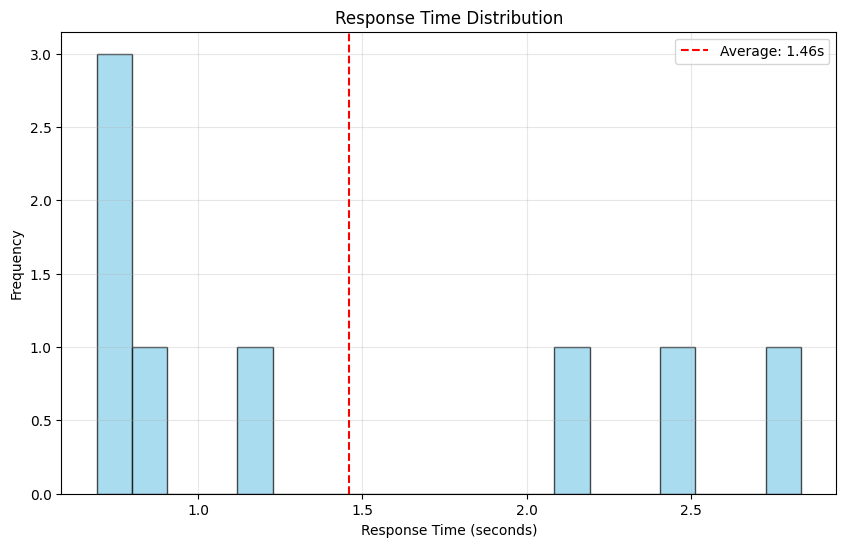

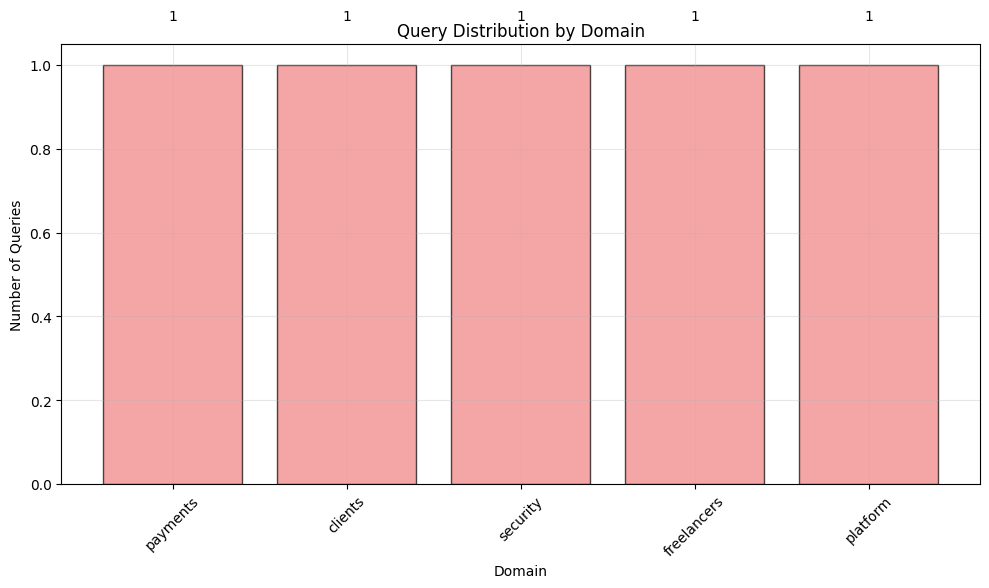

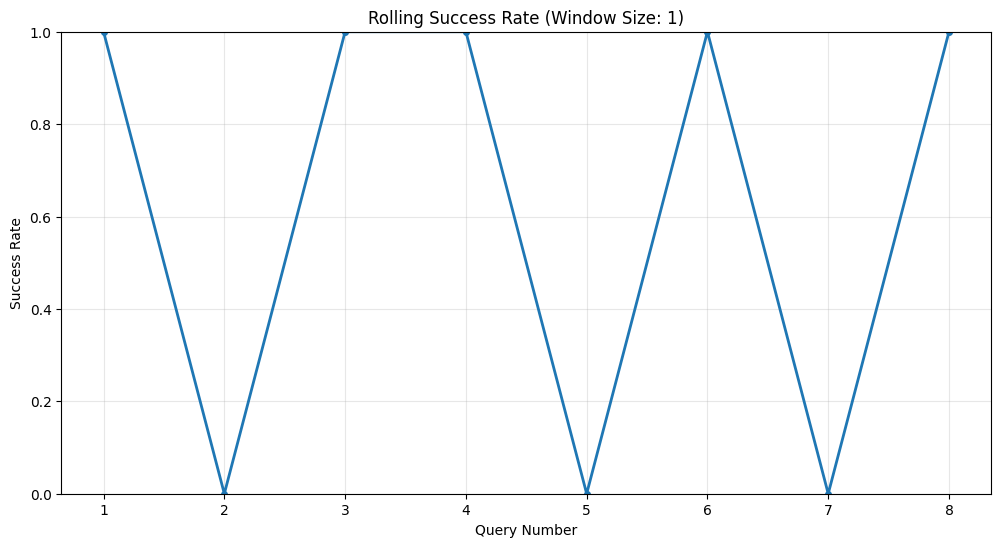

In [64]:
# Display Metrics Dashboard
print("📊 SYSTEM PERFORMANCE METRICS")
print("=" * 50)

# Show the metrics dashboard
metrics_dashboard.display_dashboard()


## Interactive Demo

Use the system interactively! Try these example queries or create your own:

**Example Queries:**
- "How do I hire a freelancer?"
- "What payment methods are accepted?"
- "Tell me about Android development services"
- "How does the escrow system work?"
- "What are the security measures?"

**Out-of-scope queries (will be properly handled):**
- "What's the weather like?"
- "How do I cook pasta?"
- "Tell me about quantum physics"


In [65]:
# Interactive Query Function
def ask_shakers(user_id: str, query: str):
    """
    Interactive function to ask questions to the Shakers RAG system.
    
    Args:
        user_id: Unique identifier for the user
        query: The question to ask
    
    Returns:
        Formatted response with answer, sources, and recommendations
    """
    result = shakers_system.process_query(user_id, query)
    shakers_system.display_query_result(result)
    return result

# Example usage:
# result = ask_shakers("demo_user", "How do payments work on Shakers?")

print("✅ Interactive system ready!")
print("💡 Use ask_shakers('your_user_id', 'your_question') to test the system")
print("📊 Use metrics_dashboard.display_dashboard() to see performance metrics")


✅ Interactive system ready!
💡 Use ask_shakers('your_user_id', 'your_question') to test the system
📊 Use metrics_dashboard.display_dashboard() to see performance metrics
